In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd

import seaborn.apionly as sns
sns.set_style("whitegrid")
sns.set_context("poster")

C:\Users\kirti\Anaconda3\lib\site-packages\seaborn\apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_)
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val,mode="mask", reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mode=="mask":
        print("using mask")
        mask=reuse_split
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    else:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return clf, Xtrain, ytrain, Xtest, ytest
    

In [3]:
df=pd.read_csv(r"C:\Users\kirti\Downloads\Clothing_Store.csv")
df.head()

,HHKEY,ZIP_CODE,REC,FRE,MON,CC_CARD,AVRG,PC_CALC20,PSWEATERS,PKNIT_TOPS,...,VALPHON,WEB,MAILED,RESPONDED,RESPONSERATE,HI,LTFREDAY,CLUSTYPE,PERCRET,RESP
0,9.955600e+12,1001,208,2,368.46,0,184.23,11,0.18,0.00,...,N,0,5,0,0.00,31.81,111.00,10,0.00,0
1,9.955600e+12,1028,6,4,258.00,1,64.50,11,0.26,0.16,...,Y,0,4,2,50.00,32.72,43.50,10,0.03,1
2,9.955600e+12,1056,327,2,77.00,0,38.50,11,1.00,0.00,...,N,0,4,0,0.00,100.00,68.60,16,0.00,0
3,9.955600e+12,1118,66,8,846.06,1,105.75,11,0.38,0.00,...,Y,0,9,6,66.67,23.27,26.96,10,0.00,0
4,9.955600e+12,1107,49,1,87.44,0,87.44,11,0.20,0.20,...,Y,0,0,0,0.00,28.52,24.50,20,0.00,0


In [4]:
df.shape

(21740, 51)

In [5]:
del df['CLUSTYPE']
del df['HHKEY'], df['ZIP_CODE'], df['REC'], df['PC_CALC20'] 
del df['STORELOY']

In [6]:
df.columns

Index(['FRE', 'MON', 'CC_CARD', 'AVRG', 'PSWEATERS', 'PKNIT_TOPS',
       'PKNIT_DRES', 'PBLOUSES', 'PJACKETS', 'PCAR_PNTS', 'PCAS_PNTS',
       'PSHIRTS', 'PDRESSES', 'PSUITS', 'POUTERWEAR', 'PJEWELRY', 'PFASHION',
       'PLEGWEAR', 'PCOLLSPND', 'AMSPEND', 'PSSPEND', 'CCSPEND', 'AXSPEND',
       'TMONSPEND', 'OMONSPEND', 'SMONSPEND', 'PREVPD', 'GMP', 'PROMOS',
       'DAYS', 'FREDAYS', 'MARKDOWN', 'CLASSES', 'COUPONS', 'STYLES', 'STORES',
       'VALPHON', 'WEB', 'MAILED', 'RESPONDED', 'RESPONSERATE', 'HI',
       'LTFREDAY', 'PERCRET', 'RESP'],
      dtype='object')

In [7]:
dftouse=df.copy()

In [8]:
#We first list the columns that are percentages:
PERCENT_VARS=[ u'PSWEATERS', u'PKNIT_TOPS', u'PKNIT_DRES', u'PBLOUSES', u'PJACKETS', u'PCAR_PNTS', u'PCAS_PNTS', u'PSHIRTS', 
              u'PDRESSES', u'PSUITS', u'POUTERWEAR', u'PJEWELRY', u'PFASHION', u'PLEGWEAR', u'PCOLLSPND']
len(PERCENT_VARS)

15

In [9]:
#we look for columns where the existence or lack thereof of a zero may be important in a classifier. We used our intuition to make these choices, believing that there is additional information encoded in say, PERCRET: if you never returned anything you might not be a budget shopper and thus someone who might have the money to shop quite a bit...
ZERO_IMPORTANT_VARS = [u'PREVPD', u'AMSPEND', u'PSSPEND', u'CCSPEND', u'AXSPEND', u'RESPONDED', u'PERCRET']

In [10]:
#We also list the columns with floating-point or integer variables that are amenable to standardization
STANDARDIZABLE = PERCENT_VARS + ZERO_IMPORTANT_VARS + [u'FRE', u'MON',  u'AVRG', u'GMP', u'PROMOS', u'DAYS', u'FREDAYS', u'MARKDOWN', u'CLASSES', u'COUPONS', u'STYLES',  u'MAILED',  u'RESPONSERATE', u'HI', u'LTFREDAY']

In [11]:
for v in df.columns:
    l=df[v].unique()
    if len(l) <= 10:
        print(v, l)

CC_CARD [0 1]
VALPHON ['N' 'Y']
WEB [0 1]
RESP [0 1]


In [12]:
#We maintain a global list INDICATORS in which the names of these columns are stored, prepending an i_ to each of these variables to denote that they are indicators.
dftouse['i_VALPHON']=(df.VALPHON=='Y')*1
del dftouse['VALPHON']
dftouse.rename(columns={'WEB':'i_WEB', 'CC_CARD':'i_CC_CARD'}, inplace=True)
INDICATORS=['i_VALPHON','i_WEB','i_CC_CARD']

In [13]:
for p in ZERO_IMPORTANT_VARS:
    dftouse['i_'+p]=(df[p] > 0.0)*1
    INDICATORS.append('i_'+p)

In [14]:
for p in PERCENT_VARS:
    dftouse['i_'+p]=(df[p] > 0.0)*1
    INDICATORS.append('i_'+p)

In [15]:
#create recent usage (1 month and 3 month),  sale-shopper (markdown+coupon)
dftouse["i_RECENT"]=1*((df.OMONSPEND > 0) | (df.TMONSPEND > 0))
dftouse["i_SAVER"]=1*((df.MARKDOWN > 0) | (df.COUPONS > 0))
INDICATORS.append("i_RECENT")
INDICATORS.append("i_SAVER")

In [16]:
dftouse.head()

,FRE,MON,i_CC_CARD,AVRG,PSWEATERS,PKNIT_TOPS,PKNIT_DRES,PBLOUSES,PJACKETS,PCAR_PNTS,...,i_PSHIRTS,i_PDRESSES,i_PSUITS,i_POUTERWEAR,i_PJEWELRY,i_PFASHION,i_PLEGWEAR,i_PCOLLSPND,i_RECENT,i_SAVER
0,2,368.46,0,184.23,0.18,0.00,0.00,0.30,0.0,0.25,...,1,0,0,0,0,1,1,1,0,1
1,4,258.00,1,64.50,0.26,0.16,0.00,0.00,0.0,0.18,...,0,1,0,0,0,0,1,1,1,1
2,2,77.00,0,38.50,1.00,0.00,0.00,0.00,0.0,0.00,...,0,0,0,0,0,0,0,0,0,1
3,8,846.06,1,105.75,0.38,0.00,0.05,0.06,0.2,0.17,...,1,0,0,0,1,1,1,0,1,1
4,1,87.44,0,87.44,0.20,0.20,0.00,0.00,0.0,0.00,...,0,0,0,0,1,0,0,0,1,1


In [17]:
#Test and Training Sets, and Standardization
from sklearn.model_selection import train_test_split
itrain, itest = train_test_split(range(dftouse.shape[0]), train_size=0.7, random_state=1983)

C:\Users\kirti\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [18]:
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [19]:
mask

array([ True,  True,  True, ..., False,  True,  True])

In [20]:
mask.shape, mask.sum()

((21740,), 15217)

In [21]:
dftrain = df[mask]
dftest = df[~mask]

In [22]:
#Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(dftrain[STANDARDIZABLE].values)
outtrain=scaler.transform(dftrain[STANDARDIZABLE].values)
outtest=scaler.fit_transform(dftest[STANDARDIZABLE].values)


In [23]:
dftouse.loc[mask, STANDARDIZABLE] = outtrain
dftouse.loc[~mask, STANDARDIZABLE] = outtest

In [24]:
lcols=list(dftouse.columns)
lcols.remove(u'RESP')
len(lcols)

68

In [ ]:
# take this data and write a classifier to predict the response, which is in the RESP column of dftouse. This response corresponds to asking the question: will a user targeted with our advertisement respond or not

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
params = {"C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
clflog, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(solver="liblinear"), params, dftouse,lcols, u'RESP',1,  mode="mask", reuse_split=mask)

using mask
BEST {'C': 0.1} 0.8497732798843399
############# based on standard predict ################
Accuracy on training data: 0.85
Accuracy on test data:     0.86
[[5344  111]
 [ 826  242]]
########################################################


In [27]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

In [28]:
#Data set is very highly asymmetric, with positive RESPonses only making up 16-17% of the samples

In [29]:
print("whole data set", dftouse['RESP'].mean())#Highly asymmetric
print("training set", dftouse['RESP'][mask].mean(), "test set", dftouse['RESP'][~mask].mean())

whole data set 0.16609935602575898
training set 0.16711572583294998 test set 0.16372834585313506


In [30]:
#This means that a classifier which predicts that EVERY customer is a negative has an accuracy rate of 83-84%. By this we mean that a classifier that predicts that
#no customer will respond to our mailing has an accuracy of 83-84%!

In [ ]:
#Is accuracy really the relevant metric?

In [32]:
ypred=clflog.predict(Xtest)
confusion_matrix(ytest, ypred)

array([[5344,  111],
       [ 826,  242]], dtype=int64)

In [33]:
#+ives (those with a 1 RESPonse) are people who respond to the mailing by going into the store and buying goods. These are also called observed positives (OP).
#-ives (those with a 0 RESPonse) are those who do not respond to the mailing. These are also called observed Negatives.

In [34]:
print("OP=", ytest.sum(), ", ON=",ytest.shape[0] - ytest.sum())

OP= 1068 , ON= 5455


In [35]:
print("PP=", ypred.sum(), ", PN=",ytest.shape[0] - ypred.sum())

PP= 353 , PN= 6170


In [36]:
#Lets categorize the costs for each one of these alternatives.

#Lets assume the amortized cost of preparing a mailing and mailing it is \$3. Lets assume additionally that the profit margin on a sale is 30% (we are a high end clothing chain).
#True Negatives cost us nothing but gain us nothing either.

In [38]:
tnc=0.0 #tnc stands for "true negative cost"

In [39]:
#From the average cost of a sale, and the 30% profit assumption, we calculate tpc, the cost of a true positive. Note: tpc must be negative, since we are talking about costs.
#The tpc takes into account the cost of mailing to the respondent, and since our mailing works, we subtract out the profit. We use the average of the AVRG column, which is the average money spent by a customer on each visit.

In [40]:
dftrain.AVRG.mean(), dftrain.FRE.mean()

(113.99388249983197, 5.089110862850759)

In [41]:
prep_and_mail=3
coupon = 15
profit_margin=0.3
tpc=prep_and_mail + coupon - np.mean(dftrain.AVRG)*profit_margin
tpc

-16.19816474994959

In [43]:
#The false negative is a lost sale for us! We didnt mail them, and they didnt spend the money. They would have if we mailed them. So we lost a certain profit per such false negative! Thus the false-negative cost, given by fnc, is
fnc = 2*np.mean(dftrain.AVRG)*profit_margin
fnc


68.39632949989918

In [44]:
#This leaves us with False positives. This is a person who would not have responded but you wasted $3 on. So the false positive cost, (fpc) is:
fpc=prep_and_mail
fpc

3

In [45]:
risk_matrix=np.array([[tnc, fpc],[fnc, tpc]])
risk_matrix

array([[  0.        ,   3.        ],
       [ 68.3963295 , -16.19816475]])

In [46]:
#u is a utility matrix
u = - risk_matrix
u

array([[ -0.        ,  -3.        ],
       [-68.3963295 ,  16.19816475]])

In [47]:
def average_profit_pp(y, ypred, u):
    c=confusion_matrix(y,ypred)
    score=np.sum(c*u)/np.sum(c)
    return score

In [48]:
#Establishing Baseline Classifiers via profit
#Dont Send to Anyone Baseline Classifier
testsize = dftouse[~mask].shape[0]
ypred_dste = np.zeros(testsize, dtype="int")
print(confusion_matrix(ytest, ypred_dste))
dsteval=average_profit_pp(ytest, ypred_dste, u)
dsteval



[[5455    0]
 [1068    0]]


-11.198417891444478

In [49]:
#Send to Everyone Baseline Classifier
ypred_ste = np.ones(testsize, dtype="int")
print(confusion_matrix(ytest, ypred_ste))
steval = average_profit_pp(ytest, ypred_ste, u)
steval


[[   0 5455]
 [   0 1068]]


0.14328375792521283

In [50]:
#Using the classifier we calculated, clflog, calculate the profit we can make
average_profit_pp(ytest, ypred, u)



-8.111055081623322

In [51]:
#Implement logistic regression with Lasso based feature selection
from sklearn.linear_model import LogisticRegression
clflog_lasso,_,_,_,_  = do_classify(LogisticRegression(solver = 'liblinear', penalty="l1"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, dftouse, lcols, u'RESP', 1, mode="not mask", reuse_split=reuse_split)
average_profit_pp(ytest, clflog_lasso.predict(Xtest), u)



using reuse split
BEST {'C': 0.1} 0.8499704278110009
############# based on standard predict ################
Accuracy on training data: 0.85
Accuracy on test data:     0.86
[[5345  110]
 [ 823  245]]
########################################################


-8.071689225000672

In [53]:
#Start with an arbitrary threshold t, and see how we fare at different thresholds for logistic regression
def t_repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred


In [54]:
#Average profit per person for t=0.5 (the usual case)
average_profit_pp(ytest,clflog.predict(Xtest), u), \
average_profit_pp(ytest,clflog_lasso.predict(Xtest), u)

(-8.111055081623322, -8.071689225000672)

In [55]:
# Confusion Matrix and average profit per person for t=0.05
confusion_matrix(ytest,t_repredict(clflog, 0.05, Xtest)), \
confusion_matrix(ytest,t_repredict(clflog_lasso, 0.05, Xtest))

(array([[2275, 3180],
        [  38, 1030]], dtype=int64), array([[2332, 3123],
        [  38, 1030]], dtype=int64))

In [56]:
average_profit_pp(ytest, t_repredict(clflog, 0.05, Xtest), u), \
average_profit_pp(ytest, t_repredict(clflog_lasso, 0.05, Xtest), u),

(0.6967728302087856, 0.7229877619886415)

In [57]:
#average profit per person for t=0.95
average_profit_pp(ytest, t_repredict(clflog, 0.95, Xtest), u)

-11.042794109289305

In [58]:
#The Lasso, for example, implements internally, a form of feature selection by setting many coefficients to zero. Let us find coefficients that are non-zero.
#We write a function nonzero_lasso which takes the fit classifier clfloglasso as an argument, and spits out a dataframe of coefficients, sorted by the absolute magnitude of the coefficients. This way we can see which features dominated the logistic regression.
def nonzero_lasso(clf):
    featuremask=(clf.coef_ !=0.0)[0]
    return pd.DataFrame(dict(feature=lcols, coef=clf.coef_[0], abscoef=np.abs(clf.coef_[0])))[featuremask].sort_values('abscoef', ascending=False)
lasso_importances=nonzero_lasso(clflog_lasso)
lasso_importances.set_index("feature", inplace=True)
lasso_importances

,coef,abscoef
feature,,
LTFREDAY,-3.064132,3.064132
i_CCSPEND,-1.365653,1.365653
FREDAYS,0.443844,0.443844
FRE,0.364103,0.364103
i_WEB,0.320748,0.320748
DAYS,0.254111,0.254111
i_PSSPEND,-0.229843,0.229843
i_AXSPEND,0.130194,0.130194
RESPONDED,-0.124784,0.124784


In [59]:
#Feature importance using pearson correlation coefficient
from scipy.stats.stats import pearsonr
correlations=[]
dftousetrain=dftouse[mask]
for col in lcols:
    r=pearsonr(dftousetrain[col], dftousetrain['RESP'])[0]
    correlations.append(dict(feature=col,corr=r, abscorr=np.abs(r)))

bpdf=pd.DataFrame(correlations).sort_values('abscorr', ascending=False)
bpdf.set_index(['feature'], inplace=True)
bpdf.head(25)

C:\Users\kirti\Anaconda3\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\kirti\Anaconda3\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


,abscorr,corr
feature,,
FRE,0.402074,0.402074
CLASSES,0.369426,0.369426
STYLES,0.354043,0.354043
RESPONDED,0.350279,0.350279
RESPONSERATE,0.328638,0.328638
MON,0.318254,0.318254
LTFREDAY,0.306694,-0.306694
SMONSPEND,0.305881,0.305881
COUPONS,0.300972,0.300972


In [60]:
#Logistic regression using f_1 score
from sklearn.linear_model import LogisticRegression
clflog_lasso_f1,_,_,_,_  = do_classify(LogisticRegression(solver = 'liblinear', \
                                    penalty="l1"), \
                                    {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, \
                                    dftouse, lcols, u'RESP', 1, \
                                    mode="not mask", reuse_split=reuse_split, \
                                      score_func="f1")

average_profit_pp(ytest, t_repredict(clflog, 0.05, Xtest), u), \
average_profit_pp(ytest, t_repredict(clflog_lasso, 0.05, Xtest), u),\
average_profit_pp(ytest, t_repredict(clflog_lasso_f1, 0.05, Xtest), u)

using reuse split
BEST {'C': 100} 0.3384802451086085
############# based on standard predict ################
Accuracy on training data: 0.85
Accuracy on test data:     0.86
[[5335  120]
 [ 814  254]]
########################################################


(0.6967728302087856, 0.7229877619886415, 0.7161844541549153)

In [61]:
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

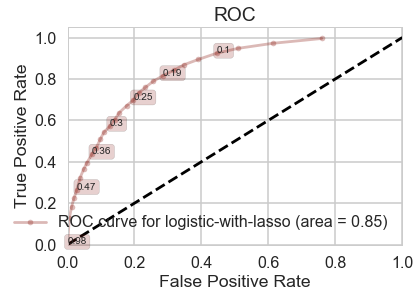

In [62]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",clflog_lasso, ytest, Xtest, labe=200, skip=50)

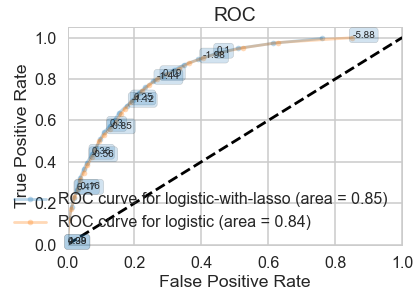

In [63]:
ax=make_roc("logistic-with-lasso",clflog_lasso, ytest, Xtest, labe=200, skip=50)
make_roc("logistic",clflog, ytest, Xtest, ax, labe=200, proba=False, skip=50);